In [1]:
# Imports
from marketsai.economies.template_single_agent.env_template_sa import TemplateSA
import scipy.io as sio
from scipy.interpolate import RegularGridInterpolator
from marketsai.utils import encode
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import csv
import json
from ray.rllib.agents.ppo import PPOTrainer
from ray.tune.registry import register_env
from ray import shutdown, init


/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


Instructions for updating:
non-resource variables are not supported in the long term


In [17]:
""" GLOBAL CONFIGS """
# Script Options
FOR_PUBLIC = True  # for publication
SAVE_CSV = False  # save learning CSV
PLOT_PROGRESS = True  # create plot with progress
SIMUL_PERIODS = 10000
# Input Directories
# Rl experiment
""" CHANGE HERE """
INPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/expINFO_native_template_sa_Sep21_PPO_run.json"
# GDSGE policy
dir_policy_folder = (
    "/Users/matiascovarrubias/Dropbox/RL_macro/Econ_algos/rbc_savings/Results/"
)

# Output Directories
if FOR_PUBLIC:
    OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/"
    OUTPUT_PATH_FIGURES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/"
    OUTPUT_PATH_TABLES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Tables/"
else:
    OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/ALL/"
    OUTPUT_PATH_FIGURES = (
        "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/ALL/"
    )
    OUTPUT_PATH_TABLES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Tables/ALL/"
    

# Plot options
sn.color_palette("Set2")
sn.set_style("ticks")  # grid styling, "dark"
# plt.figure(figure=(8, 4))
# choose between "paper", "talk" or "poster"
sn.set_context(
    "paper",
    font_scale=1.4,
)


In [18]:
""" Step 0: import experiment data and initalize empty output data """
with open(INPUT_PATH_EXPERS) as f:
    exp_data_dict = json.load(f)
print(exp_data_dict)

# UNPACK USEFUL DATA
exp_names = exp_data_dict["exp_names"]
checkpoints_dirs = exp_data_dict["checkpoints"]
progress_csv_dirs = exp_data_dict["progress_csv_dirs"]
#best_rewards = exp_data_dict["best_rewards"]


#Create output directory
exp_data_analysis_dict =  {"n_firms": [], "max rewards": [] , "time to peak": [], "Mean Agg. K": [], "S.D. Agg. K": [], "Mean Avge. K":[], "S.D. Avge. K": [], "S.D. Agg. K": [], "Max K":[], "Min K": [], 
    "Discounted Rewards":[], "Mean Price": [], "S.D. Price": [], "Max Price": [], "Min Price": [], "Discounted Rewards": [], "Mean Agg. s": [], "S.D. Agg. s": [], "Max s":[], "Min s":[]}
exp_data_analysis_econ_dict =  {"n_firms": [], "max rewards": [] , "time to peak": [], "Mean Agg. K": [], "S.D. Agg. K": [], "Mean Avge. K":[], "S.D. Avge. K": [], "S.D. Agg. K": [], "Max K":[], "Min K": [], 
    "Discounted Rewards":[], "Mean Price": [], "S.D. Price": [], "Max Price": [], "Min Price": [], "Discounted Rewards": [], "Mean Agg. s": [], "S.D. Agg. s": [], "Max s":[], "Min s":[]}
exp_data_simul_dict =  {"n_firms": [], "max rewards": [] , "time to peak": [], "Mean Agg. K": [], "S.D. Agg. K": [], "Mean Avge. K":[], "S.D. Avge. K": [], "S.D. Agg. K": [], "Max K":[], "Min K": [], 
    "Discounted Rewards":[], "Mean Price": [], "S.D. Price": [], "Max Price": [], "Min Price": [], "Discounted Rewards": [], "Mean Agg. s": [], "S.D. Agg. s": [], "Max s":[], "Min s":[]}
exp_data_simul_econ_dict =  {"n_firms": [], "max rewards": [] , "time to peak": [], "Mean Agg. K": [], "S.D. Agg. K": [], "Mean Avge. K":[], "S.D. Avge. K": [], "S.D. Agg. K": [], "Max K":[], "Min K": [], 
    "Discounted Rewards":[], "Mean Price": [], "S.D. Price": [], "Max Price": [], "Min Price": [], "Discounted Rewards": [], "Mean Agg. s": [], "S.D. Agg. s": [], "Max s":[], "Min s":[]}
# init ray
shutdown()
init()

#useful functions
def process_rewards(r, BETA):
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, len(r))):
        running_add = running_add * BETA + r[t]
        discounted_r[t] = running_add
    return discounted_r[0]

#register environment
env_label = "template_sa"
register_env(env_label, TemplateSA)

{'exp_names': ['native_template_sa_Sep21_PPO_run'], 'exp_dirs': ['/Users/matiascovarrubias/ray_results/native_template_sa_Sep21_PPO_run/PPO_template_sa_4d5bb_00001_1_2021-09-21_16-27-12'], 'progress_csv_dirs': ['/Users/matiascovarrubias/ray_results/native_template_sa_Sep21_PPO_run/PPO_template_sa_4d5bb_00001_1_2021-09-21_16-27-12/progress.csv'], 'best_rewards': [72.503327562618], 'checkpoints': ['/Users/matiascovarrubias/ray_results/native_template_sa_Sep21_PPO_run/PPO_template_sa_4d5bb_00001_1_2021-09-21_16-27-12/checkpoint_000169/checkpoint-169']}


2021-09-21 16:38:01,621	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
(raylet)   warnings.warn(
(raylet) /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ra

72.51782785942501


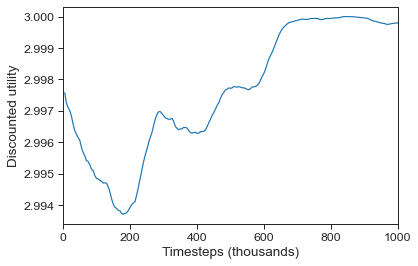

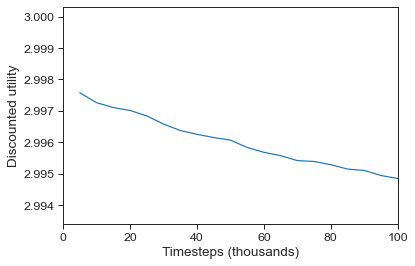

In [19]:
""" Step 1: Plot progress during learning run """

if PLOT_PROGRESS == True:
    #Big plot

    data_progress_df = pd.read_csv(progress_csv_dirs[0])
    max_rewards = abs(data_progress_df[
        "evaluation/custom_metrics/discounted_rewards_mean"
    ].max())
    print(max_rewards)
    exp_data_simul_dict["max rewards"].append(max_rewards)
    exp_data_simul_dict["time to peak"].append(0)
    exp_data_analysis_dict["max rewards"].append(max_rewards)
    exp_data_analysis_dict["time to peak"].append(0)
    data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"] = data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"] / max_rewards + 2
    
    learning_plot_big = sn.lineplot(
        data=data_progress_df,
        y="evaluation/custom_metrics/discounted_rewards_mean",
        x="episodes_total",
    )


    learning_plot_big = learning_plot_big.get_figure()
    plt.ylabel("Discounted utility")
    plt.xlabel("Timesteps (thousands)")
    plt.xlim([0, 1000])
    learning_plot_big.savefig(OUTPUT_PATH_FIGURES + "progress_BIG_" + exp_names[-1] + ".png")
    plt.show()
    plt.close()

    # small plot

    learning_plot_small = sn.lineplot(
        data=data_progress_df,
        y="evaluation/custom_metrics/discounted_rewards_mean",
        x="episodes_total",
    )


    learning_plot_small = learning_plot_small.get_figure()
    plt.ylabel("Discounted utility")
    plt.xlabel("Timesteps (thousands)")
    plt.xlim([0, 100])
    learning_plot_small.savefig(OUTPUT_PATH_FIGURES + "progress_SMALL_" + exp_names[-1] + ".png")
    plt.show()
    plt.close()


(pid=36749) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=36749) Instructions for updating:
(pid=36749) non-resource variables are not supported in the long term
(pid=36749) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
(pid=36749) Instructions for updating:
(pid=36749) non-resource variables are not supported in the long term
(pid=36749) WARNING:tensorflow:From /Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packa

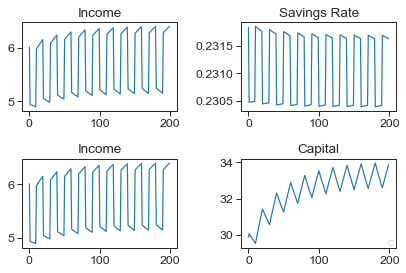

{'n_firms': [], 'max rewards': [72.51782785942501], 'time to peak': [0], 'Mean Agg. K': [], 'S.D. Agg. K': [], 'Mean Avge. K': [], 'S.D. Avge. K': [], 'Max K': [], 'Min K': [], 'Discounted Rewards': [], 'Mean Price': [], 'S.D. Price': [], 'Max Price': [], 'Min Price': [], 'Mean Agg. s': [], 'S.D. Agg. s': [], 'Max s': [], 'Min s': []}


In [20]:
""" Step 2: Congif env, Restore RL policy and then simualte analysis trajectory """


""" Step 2.0: replicate original environemnt and config """
env_horizon = 200
beta = 0.99
# environment config
env_config_analysis = {
    "horizon": 200,
    "eval_mode": False,
    "analysis_mode": True,
    "simul_mode": False,
    "max_action": 0.5,
    "rew_mean": 0,
    "rew_std": 1,
    "parameters": {
        "alpha": 0.5,
        "delta": 0.04,
        "beta": 0.99,
    },
}

# We instantiate the environment to extract information.
""" CHANGE HERE """
env = TemplateSA(env_config_analysis)
config_algo = {
    "gamma": beta,
    "env": env_label,
    "env_config": env_config_analysis,
    "horizon": env_horizon,
    "explore": False,
    "framework": "torch",
}
""" Step 2.1: restore trainer """

# restore the trainer
trained_trainer = PPOTrainer(env=env_label, config=config_algo)
trained_trainer.restore(checkpoints_dirs[0])

""" Step 2: Simulate an episode (MAX_steps timesteps) """
#shock_idtc_list = [[] for i in range(env.n_firms)]
y_list = []
s_list = []
k_list = []
rew_list = []
rew_disc = []

# loop
obs = env.reset()
for t in range(env_horizon):
    action = trained_trainer.compute_action(obs)

    obs, rew, done, info = env.step(action)
    y_list.append(info["income"])
    s_list.append(info["savings"])
    k_list.append(info["capital"])
    rew_list.append(info["rewards"])

rew_disc.append(np.mean(process_rewards(rew_list,0.98)))


""" Step 2.2: Plot analysis trajectories """

# Idiosyncratic trajectories
x = [i for i in range(200)]
plt.subplot(2, 2, 1)
sn.lineplot(x,y_list[:200])
plt.title("Income")

plt.subplot(2, 2, 2)
sn.lineplot(x,s_list[:200])
plt.title("Savings Rate")
plt.subplot(2, 2, 3)

sn.lineplot(x,y_list[:200])
plt.title("Income")

plt.subplot(2, 2, 4)
sn.lineplot(x,k_list[:200])
plt.title("Capital")

plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='lower right', prop={'size': 6})
#plt.legend(labels=[f"{i+1} firms" for i in range(env.n_firms)], loc='upper center', bbox_to_anchor=(0.5, 1.05))
plt.savefig(OUTPUT_PATH_FIGURES + "SimInds_" + exp_names[0] + ".png")
plt.show()
plt.close()
 
print(exp_data_analysis_dict)

In [ ]:
""" Step 4: Simulate the RL policy for SIMUL_PERIODS and get statistics """


""" Step 4.0: replicate original environemnt and config """
env_horizon = 200
beta = 0.98
env_config_simul = {
    "horizon": 200,
    "eval_mode": False,
    "analysis_mode": False,
    "simul_mode": True,
    "max_action": 0.5,
    "rew_mean": 0,
    "rew_std": 1,
    "parameters": {
        "alpha": 0.5,
        "delta": 0.04,
        "beta": 0.99,
    },
}

# We instantiate the environment to extract information.
""" CHANGE HERE """
env = TemplateSA(env_config_simul)
config_analysis = {
    "gamma": beta,
    "env": env_label,
    "env_config": env_config_simul,
    "horizon": env_horizon,
    "explore": False,
    "framework": "torch",
}
""" Step 4.1: restore trainer """

# restore the trainer
trained_trainer = PPOTrainer(env=env_label, config=config_analysis)
trained_trainer.restore(checkpoints_dirs[0])

""" Simulate an episode (SIMUL_PERIODS timesteps) """

y_list = []
s_list = []
k_list = []
rew_list = []

# loop
obs = env.reset()
for t in range(SIMUL_PERIODS):
    if t%env.horizon == 0:
        obs=env.reset()

    action = trained_trainer.compute_action(obs)
    obs, rew, done, info = env.step(action)
    y_list.append(info["income"])
    s_list.append(info["savings"])
    k_list.append(info["capital"])
    rew_list.append(info["rewards"])

rew_disc=process_rewards(rew_list,0.98)



 

In [ ]:
""" Step 5: config env, Restore PI (GDSGE) policy and simulate analysis trajectory """

# replicate environment
env_horizon = 1000
n_capital = 1
beta = 0.98
env_config_analysis = {
    "horizon": 200,
    "eval_mode": False,
    "analysis_mode": True,
    "simul_mode": False,
    "max_action": 0.5,
    "rew_mean": 0,
    "rew_std": 1,
    "parameters": {
        "alpha": 0.5,
        "delta": 0.04,
        "beta": 0.99,
    },
}
# We instantiate the environment to extract information.
""" CHANGE HERE """
env = TemplateSA(env_config_analysis)
config_analysis = {
    "gamma": beta,
    "env": env_label,
    "env_config": env_config_analysis,
    "horizon": env_horizon,
    "explore": False,
    "framework": "torch",
}
""" Step 5.1: import matlab struct """
""" CHANGE HERE """
dir_model = "rbc_savings"
matlab_struct = sio.loadmat(dir_policy_folder + dir_model, simplify_cells=True)
exp_data_analysis_econ_dict["time to peak"].append(
    matlab_struct["IterRslt"]["timeElapsed"]
)
exp_data_simul_econ_dict["time to peak"].append(
    matlab_struct["IterRslt"]["timeElapsed"]
)

K_grid = [
    np.array(matlab_struct["IterRslt"]["var_state"]["K"]) 
]

shock_grid = np.array([i for i in range(matlab_struct["IterRslt"]["shock_num"])])
s_on_grid = matlab_struct["IterRslt"]["var_policy"]["s"]


s_interp = RegularGridInterpolator((shock_grid,) + tuple(K_grid), s_on_grid)

def compute_action(obs, policy_list, max_action: float):
    K = obs[0]
    # shock_raw = obs[1][0]
    shock_id = obs[1][0]
    s = policy_list(np.array([shock_id] + K))
    action = 2 * s / max_action - 1
    return action

""" Step 5.2: Simulate an episode (MAX_steps timesteps) """
shock_idtc_list = []
y_list = []
s_list = [] 
c_list = [] 
k_list = []

# loop
obs = env.reset()
for t in range(env_horizon):
    action = compute_action(obs, s_interp, env.max_action)
    obs, rew, done, info = env.step(action)
    shock_idtc_list.append(obs[1])
    y_list.append(info["income"])
    s_list.append(info["savings"])
    c_list.append(info["consumption"])
    k_list.append(info["capital"])

    # k_agg_list.append(np.sum([k_list[[j][t-1] for j in range(env_loop.n_firms)]))



""" Step 5.4: Plot individual trajectories """

# Idiosyncratic trajectories
x = [i for i in range(100)]
plt.subplot(2, 2, 1)
sn.lineplot(x, y_list[:100], legend=0)
plt.title("Shock")

plt.subplot(2, 2, 2)
sn.lineplot(x, s_list[:100], legend=0)
plt.title("Savings Rate")

plt.subplot(2, 2, 3)
sn.lineplot(x, y_list[:100], legend=0)
plt.title("Income")

plt.subplot(2, 2, 4)
sn.lineplot(x, k_list[:100], legend=0)
plt.title("Capital")

plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc="lower right", prop={"size": 6})
# plt.legend(labels=[f"{i+1} firms" for i in range(env.n_firms)], loc='upper center', bbox_to_anchor=(0.5, 1.05))
plt.savefig(OUTPUT_PATH_FIGURES + "SimInd_" + exp_names + ".png")
plt.show()
plt.close()


In [ ]:
""" Step 7: Simulate the Plocy Iteration model and get statistics """

""" Step 7.0: replicate original environemnt and config """
env_horizon = 1000

n_capital = 1
beta = 0.98
env_config_analysis = {
    "horizon": 200,
    "eval_mode": False,
    "analysis_mode": False,
    "simul_mode": True,
    "max_action": 0.5,
    "rew_mean": 0,
    "rew_std": 1,
    "parameters": {
        "alpha": 0.5,
        "delta": 0.04,
        "beta": 0.99,
    },
}

# We instantiate the environment to extract information.
env = TemplateSA(env_config_simul)
config_analysis = {
    "gamma": beta,
    "env": env_label,
    "env_config": env_config_simul,
    "horizon": env_horizon,
    "explore": False,
    "framework": "torch",
}
""" Step 7.1: restore trainer """

dir_model = "rbc_savings_firm_11pts"
matlab_struct = sio.loadmat(dir_policy_folder + dir_model, simplify_cells=True)

K_grid = [np.array(matlab_struct["IterRslt"]["var_state"][f"K"])]

shock_grid = np.array([i for i in range(matlab_struct["IterRslt"]["shock_num"])])

s_on_grid = [matlab_struct["IterRslt"]["var_policy"]["s"]]

s_interp = [RegularGridInterpolator((shock_grid,) + tuple(K_grid), s_on_grid)]

def compute_action(obs, policy_list: list, max_action: float, K_grid: list):
    K = [min(max(obs[0],min(K_grid)), max(K_grid))]
    shock_raw = [obs[2]] + list(obs[1])
    shock_id = encode(shock_raw, dims=[2])
    s = [policy_list(np.array([shock_id] + K)) for i in range(env.n_firms)]
    action = np.array([2 * s / max_action - 1 for i in range(env.n_firms)])
    return action

""" Simulate an episode (SIMUL_PERIODS timesteps) """
shock_idtc_list = [[] for i in range(env.n_firms)]
y_list = [[] for i in range(env.n_firms)]
s_list = [[] for i in range(env.n_firms)]
c_list = [[] for i in range(env.n_firms)]
k_list = [[] for i in range(env.n_firms)]

# loop
obs = env.reset()
for t in range(SIMUL_PERIODS):

    if t%1000 == 0:
        obs=env.reset()
    action = compute_action(obs, s_interp, env.max_s_ij, K_grid)
    obs, rew, done, info = env.step(action)
    #shock_idtc_list.append(obs[1])
    y_list.append(info["income"])
    s_list.append(info["savings"])
    c_list.append(info["consumption"])
    k_list.append(info["capital"])


In [ ]:
""" Step 8 and final: Table with moments """

exp_table_df = pd.DataFrame.from_dict(exp_data_simul_dict)
with open(OUTPUT_PATH_TABLES + exp_names[-1]+'_BIG_TABLE.tex','w') as tf:
    tf.write(exp_table_df.to_latex())

exp_table_small_df=exp_table_df[["n_firms","max rewards", "time to peak", "Mean Agg. K", "S.D. Agg. K", "Mean Price", "S.D. Price"]]
with open(OUTPUT_PATH_TABLES + exp_names[-1]+'_SMALL_TABLE.tex','w') as tf:
    tf.write(exp_table_small_df.to_latex())

# exp_table_econ_df = pd.DataFrame.from_dict(exp_data_simul_econ_dict)
# with open(OUTPUT_PATH_TABLES + exp_names[-1]+'_econ_BIG_TABLE.tex','w') as tf:
#     tf.write(exp_table_econ_df.to_latex())

# exp_table_small_econ_df=exp_table_df[["n_firms","max rewards", "time to peak", "Mean Agg. K", "S.D. Agg. K", "Mean Price", "S.D. Price"]]
# with open(OUTPUT_PATH_TABLES + exp_names[-1]+'_econ_SMALL_TABLE.tex','w') as tf:
#     tf.write(exp_table_small_econ_df.to_latex())

In [ ]:
shutdown()